# Understanding the Gender Pay Gap

## Introduction

Gender wage disparity is a multifaceted issue rooted in societal norms and systemic biases. Despite progress made in terms of gender equality, there continues to be a disparity in wages in numerous vocations. Tozcek et al.’s 2021 study shows that even when considering relevant factors that could influence salary, there was still a discrepancy in pay. Rotman et al.’s 2022 study claims that understanding the gender wage gap and its enduring existence requires acknowledging the reality that women are paid less for their talents than men, rather than the differences in the qualities of male and female workers.

We aim to answer the question 'Is there a significant difference in the proportions of men and women who earn more than 50K in the United States?' We will use the difference in proportions of men and women as our response variable in order to analyze the disparity in income and a conduct hypothesis test, comparing both bootstrapping and asymptotic methods. To further explore our question, we will calculate a confidence interval for the true value of the difference in proportions.

Our data comes from the 1994 Census and was used to predict whether an individual earns more than $50,000 USD annually. It has 15 variables, but we will focus on two categorical variables: `Sex` ("Male, "Female") and `Income` (">50K", "<=50K").

## Methods and Results

To answer our research question, we will conduct a hypothesis test at a 5% significance level using the bootstrapping and two sample z-test methods.

We will define the null and alternate hypotheses to be $$H_0: p_{1} - p_{2}=0$$ $$H_a: p_{1} - p_{2} \neq 0,$$

where $p_{1}$ is the proportion of men that earn more than \\$50,000 USD and $p_{2}$ is the proportion of women that earn more than \\$50,000 USD.


### Preliminary Results

Before conducting the test, we will clean and wrangle the data. 

First, we load the necessary libraries and set the seed.

In [1]:
# Load libraries and set the seed
library(tidyverse)
library(tidymodels)
library(infer)
set.seed(12345)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Now, we can read and tidy the dataset. Ideally we would use the entire dataset to conduct the analysis, but our data has too many observations for Jupyter Notebook to handle. Therefore, we will take a sample of size 10,000 and use this for our analysis.

In [2]:
# Read and clean the data set
adult_data <- read_csv("https://raw.githubusercontent.com/janapc03/stat-201-group-15/main/data/adult.data")
colnames(adult_data) <- c("Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-Status", 
                          "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss", 
                          "Hours-per-Week", "Native_Country", "Income")

# Filter the selected dataset and take a sample size of 10000
adult_data <- adult_data %>%
    filter(Native_Country == "United-States") %>%
    select(Sex, Income) %>%
    rep_sample_n(size = 10000, reps = 1, replace = FALSE)
head(adult_data)
print("Figure 1: Tidied data")

Rows: 32560 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): State-gov, Bachelors, Never-married, Adm-clerical, Not-in-family, W...
dbl (6): 39, 77516, 13, 2174, 0, 40

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


replicate,Sex,Income
<int>,<chr>,<chr>
1,Male,>50K
1,Male,<=50K
1,Female,<=50K
1,Male,>50K
1,Male,>50K
1,Male,<=50K


[1] "Figure 1: Tidied data"


Now that we've clean the data, we can visualize the counts of each class.

Income,Female,Male
<chr>,<int>,<int>
<=50K,2943,4615
>50K,370,2072


[1] "Figure 2: Counts of each class"


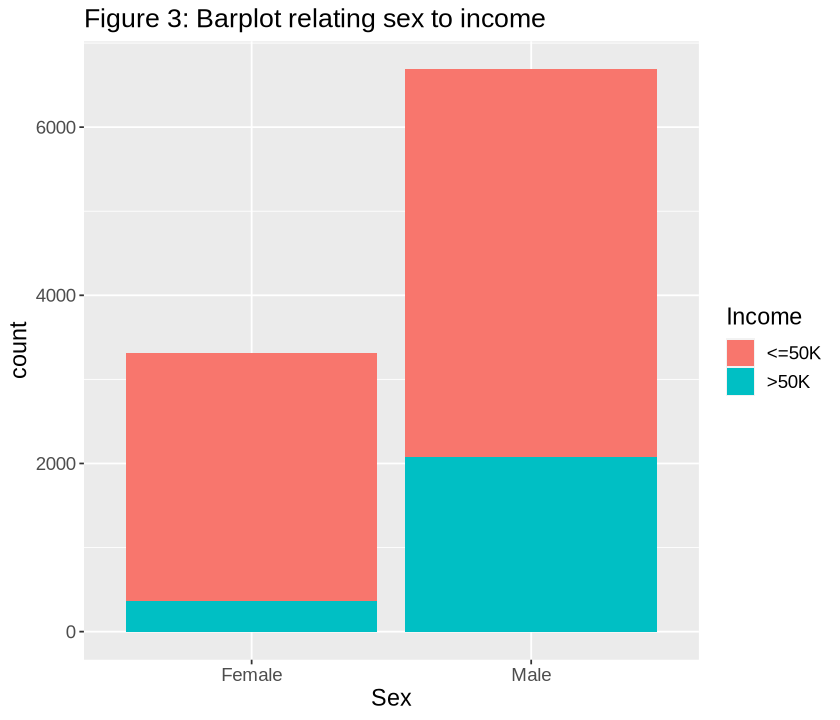

In [3]:
# Visualize counts
adult_data %>% 
    group_by(Sex, Income) %>% 
    tally() %>%
    spread(Sex, n)
print("Figure 2: Counts of each class")

# Plot the data
options(repr.plot.width = 7, repr.plot.height = 6)
ggplot(adult_data, aes(x = Sex, fill = Income)) +
    geom_bar() +
    labs(x = "Sex", title = "Figure 3: Barplot relating sex to income") +
    theme(text = element_text(size = 14), plot.title = element_text(size=16))

Based on Figures 2 and 3, we have reason to believe that the proportion of men who earn more than \\$50,000 is not equal to the proportion of women who earn more than \\$50,000. However, we will conduct the hypothesis test to see if this difference is statistically significant.

### Hypothesis Test Using the Bootstrapping Method

The first method that we will use to conduct the hypothesis test is bootstrapping.

First, we calculate the observed difference in proportions.

In [4]:
# Compute estimate
obs_diff_prop <- adult_data %>%
    specify(formula = Income ~ Sex, success = ">50K") %>%
    calculate(stat = "diff in props", order = c("Male", "Female"))
obs_diff_prop
print("Figure 4: Observed difference in proportions")

stat
<dbl>
0.1981737


[1] "Figure 4: Observed difference in proportions"


To produce the bootstrapped null distribution, we will generate 1000 samples and calculate the proportion of men who earn more than \\$50,000 minus the proportion of women who earn more than \\$50,000 USD for each sample. 

In [5]:
# Generate bootstrapped null distribution using 1000 samples
bootstrapped_null <- adult_data %>%
    specify(formula = Income ~ Sex, success = ">50K") %>%
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>%
    calculate(stat = "diff in props", order = c("Male", "Female"))

head(bootstrapped_null)
print("Figure 5: Difference in proportions for each bootstrap sample")

replicate,stat
<int>,<dbl>
1,-0.009012085
2,0.004078084
3,-0.001789923
4,0.016265482
5,0.000467003
6,0.005432239


[1] "Figure 5: Difference in proportions for each bootstrap sample"


Now, we can visualize the distribution of the differences in proportions for the samples in comparison to the observed test statistic.

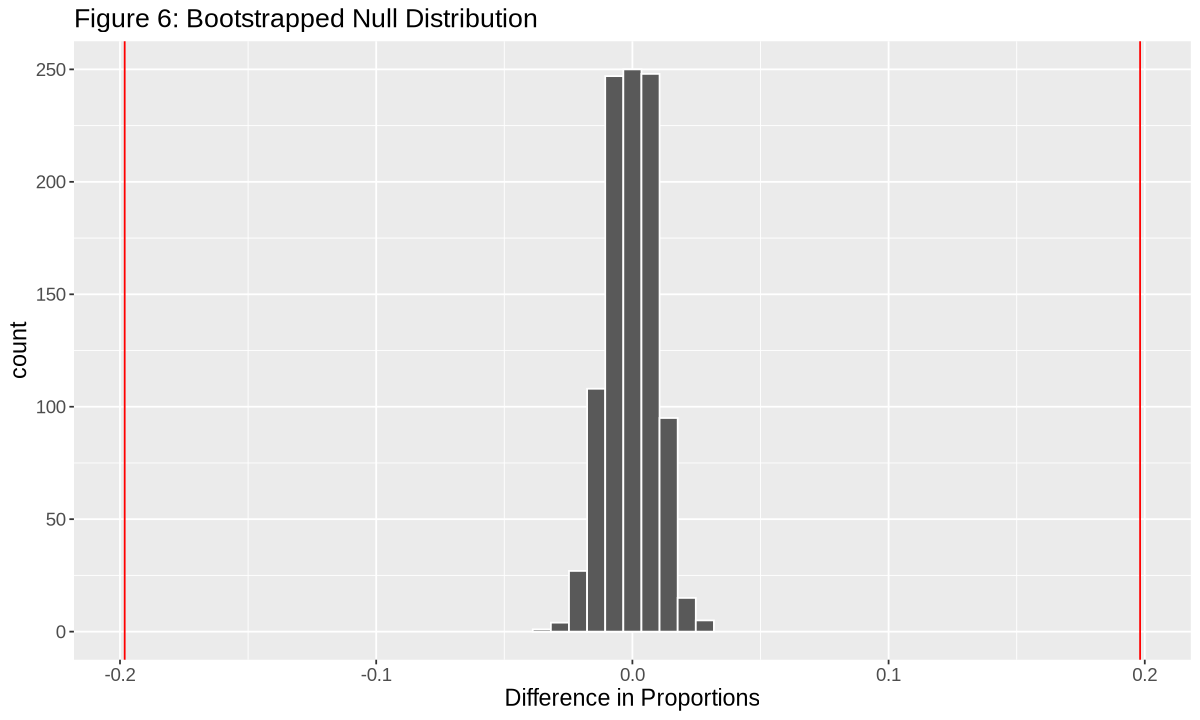

In [17]:
# Plot the bootstrapped null distribution
options(repr.plot.width = 10, repr.plot.height = 6)
bootstrapped_dist <- bootstrapped_null %>% 
    visualize(bins = 10) + 
    geom_vline(color = "red", xintercept = obs_diff_prop$stat) +
    geom_vline(color = "red", xintercept = -obs_diff_prop$stat) +
    labs(x = "Difference in Proportions", title = "Figure 6: Bootstrapped Null Distribution") +
    theme(text = element_text(size = 14), plot.title = element_text(size=16))

bootstrapped_dist

From Figure 6, we see that the observed test statistic is very far from the null distribution. To investigate this further, we will calculate the p-value for the test.

In [7]:
# Calculate the p-value for the bootstrap method
p_value_boot <- bootstrapped_null %>%
    get_p_value(obs_stat = obs_diff_prop, direction = "both")
p_value_boot
print("Figure 7: P-value for bootstrap method")

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


[1] "Figure 7: P-value for bootstrap method"


A true p-value of 0 is impossible, but the get_p_value() function returns an approximation based on the number of reps chosen. Since we used 1000 reps, the p-value is likely less than 3/1000 and therefore approximately 0. This is further supported by Figure 6, which suggests that the probability of obtaining the observed test statistic or something more extreme is very low.

### Hypothesis Test Using Two Sample z-test

We can also use an asymptotic method for our hypothesis test. Before conducting the test, we will check the appropriate assumptions.

**Independent Observations:** We have taken a random sample from the census data, so this condition is met.

**Sample Size:** The pooled success rate is 
$\\(370+2072)/10000=0.2442$

Now we can determine the expected pooled success and failure counts:

$0.24*(370+2948)= 796.32, 
\\ 0.76*(370+2948)= 2521.68$

$0.24*(2072+4615)= 1604.88
\\0.76*(2072+4615)= 5082.12$

Since the number of pooled successes and failures for each group are greater than 10, this condition is satisfied.

**Independent Selection of Samples:** We do not have reason to suspect that a woman selected would have any relationship to a man selected.

Thus, all required conditions are met.

Since we are comparing the proportions of two independent samples, we will use a two sample z-test. For simplicity, we will use the prop.test() function to conduct the test and view the overall results, focusing primarily on the p-value and 95% confidence interval.

In [8]:
# Conduct the two sample z-test
z_test_result <- tidy(
        prop.test(x = table(adult_data$Sex, adult_data$Income),
                  n = nrow(adult_data),
                  alternative = "two.sided",
                  correct = FALSE))
z_test_result
print("Figure 8: Results of the two sample z-test")

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.8883187,0.6901451,471.4028,1.586728e-104,1,0.1827503,0.213597,2-sample test for equality of proportions without continuity correction,two.sided


[1] "Figure 8: Results of the two sample z-test"


We see that the two sample z-test gives a p-value of 1.586728e-104, with a test statistic of $\sqrt(471.4028)=21.71$ and a 95% confidence interval of $[0.183, 0.214]$.

### Interpretation

The bootstrapping method gave an approximate p-value of 0 while the asymptotic method gave a p-value of 1.586728e-104. We can see that these p-values are smaller than 0.05, and therefore for both hypothesis tests we will reject the null hypothesis at a 5% significance level. This means that there is enough evidence to suggest that the proportion of men who earn more than \\$50,000 is not equal to the proportion of women who earn more than \\$50,000. Additionally, we calculated a 95% confidence interval of $[0.183, 0.214]$ for the true difference in proportions. This matches with our hypothesis test results of rejecting the null hypothesis. Since zero is not in the range $[0.183, 0.214]$, we have evidence that there is a difference in the proportion of men and women who earn more than \\$50,000. Therefore, we are 95% confident that the true difference in proportions of men and women who earn more than \\$50,000 is between 0.183 and 0.214.

### Method Analysis

For this analysis, we believe that both of the bootstrapping and asymptotic methods are appropriate. We got a very small p-value from both of our hypothesis tests which can be considered basically equivalent. We consider both methods to be equivalent as we have a large sample size(n=10000) with high repetitions(reps = 1000), which results in our bootstrapped sampling distribution closely resembling the sampling distribution for the population of working adults in the United States. Therefore, using this distribution for our analysis should result in an accurate estimate of the p-value. Similarly for our theory based approach, we satisfied all conditions (i.e. our sample size is large enough and samples were chosen independently without bias). Thus, using a two sample z-test should approximate the true difference in proportion relatively well, and our p-value should be accurate. A p-value of 1.586728e-104 reinforces our idea that both methods are appropriate for our analysis. While we'd consider bootstrapping to be more "trustworthy," as it represents the true sampling distribution and does not approximate it using CLT, it is also more computationally intensive and using a theory based approach may be a better alternative.

## Discussion

**Summary and Impact**

Our hypothesis tests using the bootstrap method and asymptotic methods both resulted in a p-value smaller than our chosen significance level of 5%. Therefore, we rejected our null hypothesis, as evidence suggests that there is a statistically significant difference between the proportion of men who earn over 50K and the proportion of women who earn over 50K. Under our 2 sample z-test, we obtained a 95% confidence interval from 0.183 to 0.214. The null hypothesis states that the difference in proportions should be zero, but zero lies outside of our confidence interval. This provides evidence that further supports our decision to reject the null hypothesis. However, we note that we may be at risk of making a Type 1 Error, as we've rejected the null hypothesis. 

While our analysis suggests that there is a significant difference in the proportions of men and women who earn over 50K, further research can be done to investigate other factors that can affect income. These findings could raise more awareness and address the disparity in income between genders, bringing more attention to issues regarding gender inequality and encourage an improvement in equity practices in various industries.


**Expectations**

When we visualized our data in Figures 2 and 3, the results suggested that there is a significant difference in the proportion of men and women who make more than 50K. Furthermore, we calculated the observed statistic and found it to be 0.202. From this, we anticipated that we would reject the null hypothesis, which stated that the proportions of men and women who earn more than 50K is equal. In our hypothesis test, both the bootstrap and asymptotic methods gave us very small p-values, which confirmed our initial expectations and provided strong evidence of a statistically significant difference in the proportions of men and women with incomes over 50K.


**Future Questions**

What other factors can contribute to the difference in income levels of men and women? 

How do the income levels of men and women change across other regions and countries?

How do demographics (such as race, age, and ethnicity) affect income levels?

## References

Becker, Barry and Kohavi, Ronny. (1996). Adult. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20

Toczek, L., Bosma, H., & Peter, R. (2021). “The Gender Pay Gap: Income Inequality Over Life Course - A Multilevel Analysis.” Frontiers in sociology, 6, 815376. https://doi.org/10.3389/fsoc.2021.815376

Rotman, A., & Mandel, H. (2023). “Gender-Specific Wage Structure and the Gender Wage Gap in the U.S. Labor Market.” Social indicators research, 165(2), 585–606. https://doi.org/10.1007/s11205-022-03030-4